# Here’s a detailed explanation of the code:

Imports:

gym: A library for creating and interacting with reinforcement learning environments.
numpy (np): A library for numerical operations in Python.
tensorflow (tf): A deep learning library used to build and train neural networks.
tensorflow.keras.layers: Provides layers for building neural networks.
matplotlib.pyplot (plt): A plotting library for visualizing data.
collections.deque: A double-ended queue to store experiences in memory.
random: A library for generating random numbers and choices.

Environment Setup:
=
env = gym.make('CartPole-v1'): Creates an instance of the CartPole environment where a cart moves along a track to balance a pole.
state_size = env.observation_space.shape[0]: Retrieves the size of the state space, i.e., the number of features describing the state.
action_size = env.action_space.n: Retrieves the number of possible actions the agent can take.
Define the DQN Model:
=
build_model(state_size, action_size): A function that creates a Deep Q-Network (DQN) using TensorFlow and Keras. The network has:
Two dense layers with 24 neurons each and ReLU activation.
An output layer with a linear activation that provides Q-values for each action.
model.compile(): Configures the model for training using the Adam optimizer and mean squared error (MSE) loss function.
Define the DQN Agent Class:
=
__init__(self, state_size, action_size): Initializes the agent with state and action sizes, a replay memory (deque), and hyperparameters like gamma (discount factor), epsilon (exploration rate), and its decay. It also creates the main and target models.
update_target_model(self): Copies the weights from the main model to the target model to stabilize training.
act(self, state): Chooses an action based on the exploration-exploitation trade-off. With probability epsilon, it picks a random action (exploration); otherwise, it selects the action with the highest Q-value from the model (exploitation).
remember(self, state, action, reward, next_state, done): Stores experiences (state, action, reward, next state, done flag) in memory.
replay(self, batch_size): Samples a batch of experiences from memory and trains the model. It calculates the target Q-value for each experience and updates the model. Reduces epsilon over time to shift from exploration to exploitation.
Training the DQN Agent:
=
agent = DQNAgent(state_size, action_size): Creates an instance of the DQN agent.
episodes = 1000: Number of episodes to train the agent.
batch_size = 32: Size of the batch used for training in each replay step.
In the training loop:
The environment is reset to start a new episode.
The agent interacts with the environment, stores experiences, and updates its model based on the experiences.
After each episode, the target model is updated and the total reward is recorded.
if len(agent.memory) > batch_size: Ensures there are enough experiences in memory to train the model.
Plotting and Finalizing:
=
plt.plot(rewards_list): Plots the rewards obtained during training to visualize the learning progress.
plt.xlabel('Episode') and plt.ylabel('Reward'): Label the x-axis and y-axis of the plot.
plt.title('DQN Training Progress'): Adds a title to the plot.
plt.show(): Displays the plot.
env.close(): Closes the environment when training is complete.

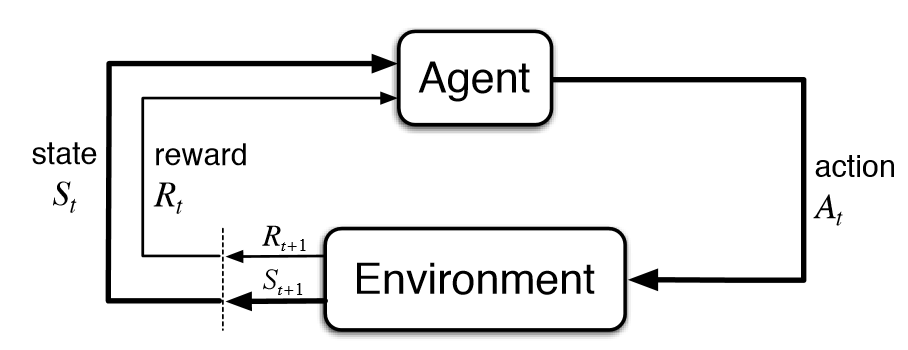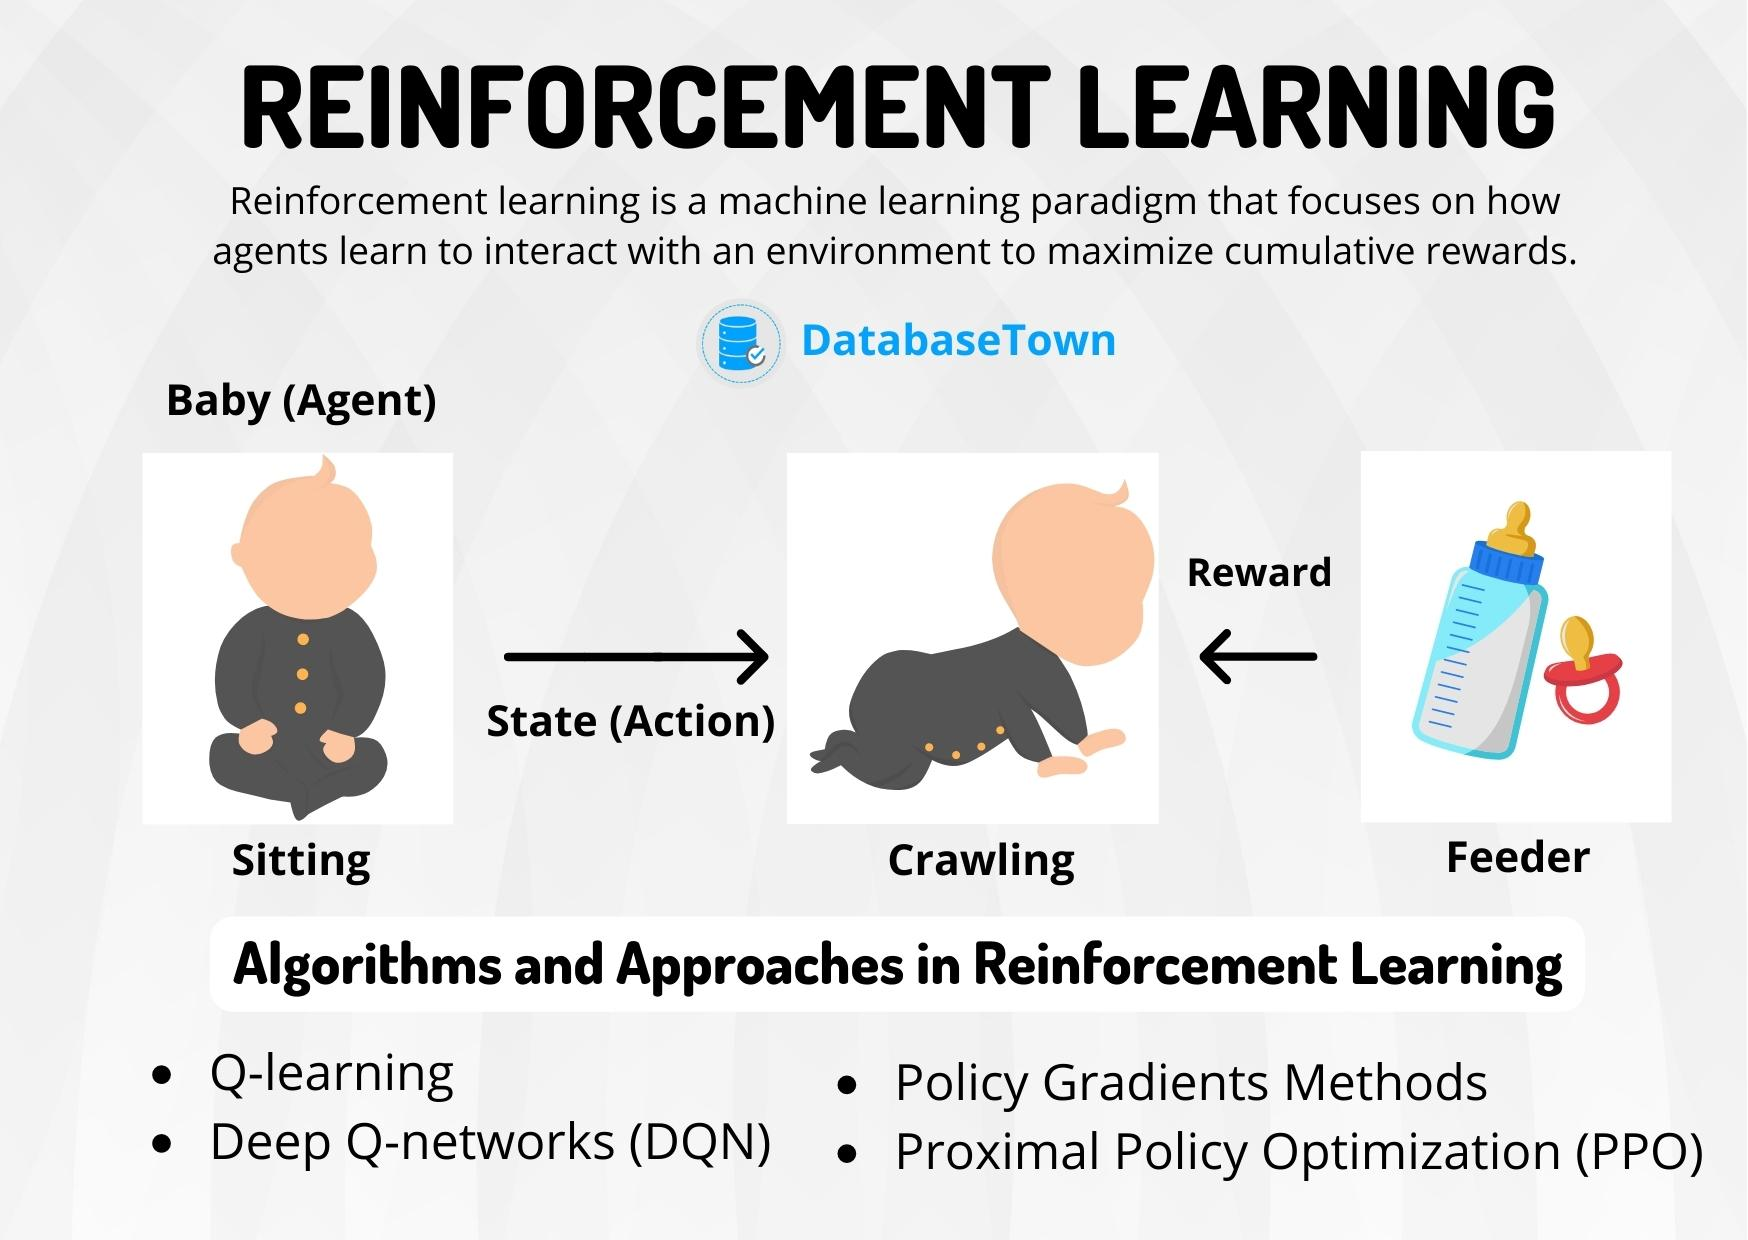

In [ ]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from collections import deque
import random

# Create a simple car driving environment
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Define the DQN model
def build_model(state_size, action_size):
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(state_size,)))  # Correct input shape definition
    model.add(layers.Dense(24, activation='relu'))
    model.add(layers.Dense(24, activation='relu'))
    model.add(layers.Dense(action_size, activation='linear'))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
    return model

# Define a class for the DQN Agent
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  # Discount factor
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = build_model(state_size, action_size)
        self.target_model = build_model(state_size, action_size)
        self.update_target_model()

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        q_values = self.model.predict(state)
        return np.argmax(q_values[0])

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target += self.gamma * np.amax(self.target_model.predict(next_state)[0])
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Training the DQN agent
agent = DQNAgent(state_size, action_size)
episodes = 1000
batch_size = 32

rewards_list = []

for e in range(episodes):
    state = env.reset()
    state = np.array(state)  # Ensure state is a NumPy array
    state = np.reshape(state, [1, state_size])
    done = False
    total_reward = 0

    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        next_state = np.array(next_state)  # Ensure next_state is a NumPy array
        next_state = np.reshape(next_state, [1, state_size])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

        if done:
            agent.update_target_model()
            rewards_list.append(total_reward)
            print(f"Episode {e+1}/{episodes} - Reward: {total_reward}")

    if len(agent.memory) > batch_size:
        agent.replay(batch_size)

# Plotting the training rewards
plt.plot(rewards_list)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('DQN Training Progress')
plt.show()

# Close the environment
env.close()